In [546]:
import gizmo_analysis as gizmo
import h5py
import halo_analysis as halo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.interpolate as interp
import scipy.signal as signal
import utilities as ut


In [547]:
sim = "m12i"
sim_dir = "/Users/z5114326/Documents/simulations/"
fire_dir = sim_dir + sim + "/" + sim + "_res7100"

proc_file = sim_dir + sim + "/" + sim + "_processed.hdf5"
proc_data = h5py.File(proc_file, "r")  # open processed data file

snap = fire_dir + "/snapshot_times.txt"
snap_data = pd.read_table(snap, comment="#", header=None, sep=r"\s+")
snap_data.columns = [
    "index",
    "scale_factor",
    "redshift",
    "time_Gyr",
    "lookback_time_Gyr",
    "time_width_Myr",
]


In [548]:
halt = halo.io.IO.read_tree(simulation_directory=fire_dir, assign_hosts_rotation=True)


# in utilities.simulation.Snapshot():
* reading:  Users/z5114326/Documents/simulations/m12i/m12i_res7100/snapshot_times.txt

* read 17859038 halos from:  Users/z5114326/Documents/simulations/m12i/m12i_res7100/halo/rockstar_dm/catalog_hdf5/tree.hdf5


# in gizmo_analysis.gizmo_track.ParticleCoordinate():
  read 1 host (position, velocity, principal axes) from:  Users/z5114326/Documents/simulations/m12i/m12i_res7100/track/host_coordinates.hdf5
  host1 position = (41792.15, 44131.23, 46267.68) [kpc comoving]
  host1 velocity = (-52.2, 73.6, 94.7) [km/s]
  host1 axis ratios = (0.16, 0.16, 0.99)


In [549]:
grp_lst = proc_data["it000"]["snapshots"]["snap600"]["group_id"][()]

unique_values, counts = np.unique(grp_lst, return_counts=True)
grp_unq = [grp for grp, cnts in zip(unique_values, counts) if cnts > 5]
grp_unq = grp_unq[1:]  # exclude grp = 0

grp_unq

[1920378, 8580896, 13687078, 19898495]

In [581]:
host_grp_test = grp_unq[3]
host_grp_test

19898495

In [582]:
idx = np.where(halt["tid"] == host_grp_test)[0][0]
init_snap = halt["snapshot"][idx]

In [583]:
next_idx = halt["descendant.index"][idx]
halt.prop("host.distance", next_idx), halt.prop("snapshot", next_idx)

(array([0., 0., 0.], dtype=float32), 478)

In [584]:
time = snap_data[snap_data["index"] == init_snap]["time_Gyr"].values[0]
approx_end_time = time - 1

end_idx = np.argmin(np.abs(approx_end_time - snap_data["time_Gyr"]))
end_snap = snap_data["index"][end_idx]

In [585]:
evolve_dict = {}
evolve_dict[str(host_grp_test)] = {}

evolve_dict[str(host_grp_test)]["snap"] = []
evolve_dict[str(host_grp_test)]["pos"] = []
evolve_dict[str(host_grp_test)]["vel"] = []

# put final data in
evolve_dict[str(host_grp_test)]["snap"].append(halt.prop("snapshot", next_idx))
evolve_dict[str(host_grp_test)]["pos"].append(halt.prop("host.distance", next_idx))
evolve_dict[str(host_grp_test)]["vel"].append(halt.prop("host.velocity", next_idx))

# put init data in
evolve_dict[str(host_grp_test)]["snap"].append(init_snap)
evolve_dict[str(host_grp_test)]["pos"].append(halt.prop("host.distance", idx))
evolve_dict[str(host_grp_test)]["vel"].append(halt.prop("host.velocity", idx))

for _ in range(end_snap, init_snap + 1):
    idx = halt["progenitor.main.index"][idx]

    evolve_dict[str(host_grp_test)]["snap"].append(halt["snapshot"][idx])
    evolve_dict[str(host_grp_test)]["pos"].append(halt.prop("host.distance", idx))
    evolve_dict[str(host_grp_test)]["vel"].append(halt.prop("host.velocity", idx))

In [586]:
x_lst = np.array(evolve_dict[str(host_grp_test)]["pos"])[:, 0]
y_lst = np.array(evolve_dict[str(host_grp_test)]["pos"])[:, 1]
z_lst = np.array(evolve_dict[str(host_grp_test)]["pos"])[:, 2]

vx_lst = np.array(evolve_dict[str(host_grp_test)]["vel"])[:, 0]
vy_lst = np.array(evolve_dict[str(host_grp_test)]["vel"])[:, 1]
vz_lst = np.array(evolve_dict[str(host_grp_test)]["vel"])[:, 2]

time_lst = np.array([snap_data["time_Gyr"][idx] for idx in evolve_dict[str(host_grp_test)]["snap"]])

# Step 1: Sort by time
sorted_indices = np.argsort(time_lst)

# Step 2: Reorder data arrays based on sorted indices
x_lst = x_lst[sorted_indices]
y_lst = y_lst[sorted_indices]
z_lst = z_lst[sorted_indices]

vx_lst = vx_lst[sorted_indices]
vy_lst = vy_lst[sorted_indices]
vz_lst = vz_lst[sorted_indices]

time_lst = time_lst[sorted_indices]

km_convert = 3.086e16
time_convert = (10e9) * 365.25 * 24 * 60 * 60

Text(0.5, 1.0, 'Galaxy Merger Trajectory with Sigma Smoothing')

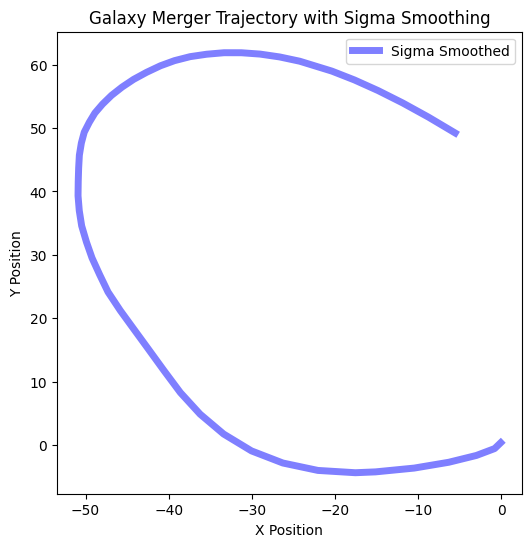

In [588]:
# Threshold to decide between quadratic and cubic fitting
pos_threshold = 7.5

# Arrays to store smoothed data
x_smooth_all = []
y_smooth_all = []

# Piecewise fitting
for i in range(1, len(x_lst)):
    # Get the previous and current points
    pos_init = np.array([x_lst[i - 1], y_lst[i - 1]])
    vel_init = np.array([vx_lst[i - 1], vy_lst[i - 1]])
    t_init = time_lst[i - 1]

    pos_final = np.array([x_lst[i], y_lst[i]])
    vel_final = np.array([vx_lst[i], vy_lst[i]])
    t_final = time_lst[i]

    dpos = np.abs(
        np.linalg.norm([x_lst[i - 1], y_lst[i - 1], z_lst[i - 1]])
        - np.linalg.norm([x_lst[i], y_lst[i], z_lst[i]])
    )

    pos_init = pos_init * km_convert
    pos_final = pos_final * km_convert
    t_init = t_init * time_convert
    t_final = t_final * time_convert

    # Construct arrays of time, position, and velocity
    t = np.array([t_init, t_final])
    x_pos = np.array([pos_init[0], pos_final[0]])
    y_pos = np.array([pos_init[1], pos_final[1]])
    vx_pos = np.array([vel_init[0], vel_final[0]])  # Velocities for x and y
    vy_pos = np.array([vel_init[1], vel_final[1]])

    # Decide whether to use quadratic or cubic spline
    if dpos < pos_threshold:
        # Use quadratic spline (PCHIP) if velocity change is small
        cs_x = interp.CubicSpline(t, x_pos, bc_type="natural")  # For X position
        cs_y = interp.CubicSpline(t, y_pos, bc_type="natural")  # For Y position

        sample_step = 1
    else:
        # Use cubic spline if velocity change is large
        cs_x = interp.CubicSpline(t, x_pos, bc_type=((1, vx_pos[0]), (1, vx_pos[1])))  # For X position
        cs_y = interp.CubicSpline(t, y_pos, bc_type=((1, vy_pos[0]), (1, vy_pos[1])))  # For Y position

        sample_step = 10

    # Generate smooth interpolated points for the current segment
    t_smooth = np.linspace(t_init, t_final, sample_step)  # More points for smoothing
    x_smooth = cs_x(t_smooth)
    y_smooth = cs_y(t_smooth)

    # Append smooth points to the lists
    x_smooth_all.extend(x_smooth)
    y_smooth_all.extend(y_smooth)


# Step 2: Smoothing with Savitzky-Golay filter (or Gaussian filter)
window_length = 12  # Adjust window size for smoothing
polyorder = 3  # Polynomial order for Savitzky-Golay filter

x_all_con = np.array(x_smooth_all) / km_convert
y_all_con = np.array(y_smooth_all) / km_convert

# Apply Savitzky-Golay filter to the interpolated data
x_plt = signal.savgol_filter(x_all_con, window_length, polyorder)
y_plt = signal.savgol_filter(y_all_con, window_length, polyorder)

# Plot results
plt.figure(figsize=(6, 6))
# plt.plot(x_lst, y_lst, "o-", label="Original")
# plt.plot(x_all_con, y_all_con, "g-", alpha=0.5, label="Adaptive Interpolation")  # Before smoothing
plt.plot(x_plt, y_plt, "b-", lw=5, alpha=0.5, label="Sigma Smoothed")  # Smoothed data
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.title("Galaxy Merger Trajectory with Sigma Smoothing")
# plt.xlim((-50, 50))
# plt.ylim((-50, 50))